**Day 6 - June 10 2022**

| Student                       | ID        |
| -------------                 |:---------:|
| Benjamin Starostka Jakobsen   | s184198   |
| Muhammad REDACTED             | REDACTED  |
| Victor REDACTED               | REDACTED  |

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare

sns.set_style("white")

# Exercise 7
# Simulated annealing

## 1
**Implement simulated annealing for the travelling salesman. As
proposal, permute two random stations on the route. As
cooling scheme, you can use e.g. $T_k = 1/\sqrt{1 + k}$ or
$T_k = 1/\log(k + 1)$, feel free to experiment with different
choices. The route must end where it started. Initialise with a
random permutation of stations.**

### (a)
**Have input be positions in the plane of the n stations.
Let the cost of going i → j be the Euclidian distance
between station i and j.
Plot the resulting route in the plane.
Debug with stations on a circle**

In [ ]:
def generate_stations(n, random=False):
    randProba = lambda a: a / sum(a)
    population = 500
    r = 1  # radius
    t = np.linspace(0, 2 * np.pi - (2 * np.pi / n), n)
    if random:
        t = np.linspace(0, 2 * np.pi - 0.05, population, endpoint=False)[
            np.random.choice(
                range(population),
                n,
                replace=False,
                p=randProba(np.random.random(population)),
            )
        ]
    x = r * np.cos(t)
    y = r * np.sin(t)

    coords = zip(x, y)

    station_coords = {}
    for i, s in enumerate(coords):
        station_coords[i + 1] = s

    return station_coords


n = 8
station_coords = generate_stations(n, random=True)

We generate $n$ stations around the unit circle with possibly random coordinates.

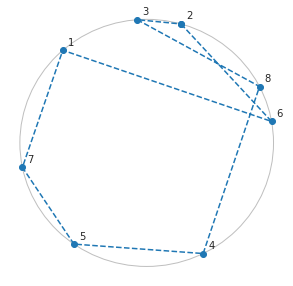

In [ ]:
def draw_route(route, station_coords):
    fig, ax = plt.subplots(figsize=(5, 5))

    circ = plt.Circle((0, 0), radius=1, edgecolor="grey", alpha=0.5, facecolor="None")
    ax.add_patch(circ)

    # prev = station_coords[0]
    x, y = [], []
    for i in route:
        x += [station_coords[i][0]]
        y += [station_coords[i][1]]
        ax.annotate(
            i,
            (station_coords[i][0], station_coords[i][1]),
            xytext=(5, 5),
            textcoords="offset points",
        )

    # Loop around
    x += [station_coords[route[0]][0]]
    y += [station_coords[route[0]][1]]

    ax.plot(x, y, linestyle="--")

    ax.scatter(x, y)
    ax.axis("off")
    plt.show()


# Generate random starting state
s_0 = np.random.choice(np.arange(1, n + 1), n, replace=False)
s_0
draw_route(s_0, station_coords)

The cost function $f(s)$ compute the total distance of traveling the route $s$. Using the coordinates of the stations in the route and euclidian distance.

In [ ]:
def cost_function_euclidian(s, coords):
    n = len(s)
    distances = []
    for i in range(n):
        ## wrap around last state
        if i + 1 == n:
            distances += [
                np.sqrt(
                    (coords[s[i]][0] - coords[s[0]][0]) ** 2
                    + (coords[s[i]][1] - coords[s[0]][1]) ** 2
                )
            ]
        else:
            distances += [
                np.sqrt(
                    (coords[s[i]][0] - coords[s[i + 1]][0]) ** 2
                    + (coords[s[i]][1] - coords[s[i + 1]][1]) ** 2
                )
            ]

    distances = np.array(distances)
    total_dist = np.sum(distances)
    return total_dist


test_coords = {0: (0, 0), 1: (5, 0), 2: (5, 3)}
test_s = [0, 1, 2]
cost_function_euclidian(test_s, test_coords)

13.8309518948453

Sampling a new route $s^{*}$from the proposal distribution $q(s^{*}|s)$ is to randomly chose 2 stations in $s$ and permute them to create $s^{*}$.

This is a symetric proposal distribution.

In [ ]:
# Sample from proposal distribution q


def permute_route(s):
    n = len(s)
    s_star = np.copy(s)
    idx = np.random.choice(range(n), 2, replace=False)
    tmp = s_star[idx[0]]
    s_star[idx[0]] = s_star[idx[1]]
    s_star[idx[1]] = tmp
    return s_star


test = np.arange(1, 9)
print(test)
print(permute_route(test))

[1 2 3 4 5 6 7 8]
[2 1 3 4 5 6 7 8]


$$
\alpha = \min(1, \frac{p(s^{*})q(s^{*}|s)}{p(s)q(s|s^{*})}) = \min(1, \frac{e^{\frac{-f(s^{*})}{T}}}{e^{\frac{-f(s)}{T}}}) = \min(1, \exp(\frac{f(s) - f(s^{*})}{T}))
$$

Assuming two proposal samples $s^{*}_1$ and $s^{*}_2$ with $f(s^{*}_1) < f(s^{*}_2)$, when compared to the current state $s$, 
* Their acceptance ratio will be $\alpha_1  \geq \alpha_2$. Indeed, a state with a lower cost  is more likely, by definition of $e^{-\frac{f(x)}{T}}$.
* If the temperature is high, the probability distribution over the state-space is more 'uniform'. If the temperature is low, the probability distribution peaks around states with low cost  and the probabilities for states with high cost become very low.

In [ ]:
def MH_algorithm_TSP_a(coords, s_0, N_iter, cooling="sqrt"):
    T = 1
    s = s_0
    f_s = cost_function_euclidian(s, coords)
    count_accept = 0

    costs = [f_s]
    temperatures = [T]
    for k in range(N_iter):
        # Sample s* from proposal distribution q
        s_star = permute_route(s)
        f_s_star = cost_function_euclidian(s_star, coords)

        # Acceptance probability = min(1, p(s*)/ p(s)) (q symetric)
        alpha = min(1, np.exp((f_s - f_s_star) / T))

        if np.random.uniform() < alpha:
            # Accept
            s = s_star
            f_s = f_s_star
            count_accept += 1

        # Else, reject and s stays s.

        # Keep trace of the iterations
        costs += [f_s]
        temperatures += [T]

        # Update the temperate
        # Cooling scheme
        if cooling == "sqrt":
            T = 1 / np.sqrt(1 + k)
        elif cooling == "log":
            T = 1 / np.log(k + 1)
        elif cooling == "linear":
            T = 1 - (1 * k / N_iter)

    # The optimal route is the last state after all iterations of the algorithm.
    s_opti = s

    print(f"Acceptance of proposal: {100 * count_accept / N_iter}%")

    return s_opti, costs, temperatures

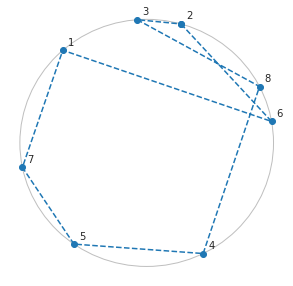

Acceptance of proposal: 1.2%


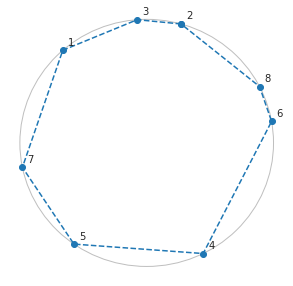

In [ ]:
N_iter = 500
draw_route(s_0, station_coords)
s_opti, costs, temperatures = MH_algorithm_TSP_a(
    station_coords, s_0, N_iter, cooling="sqrt"
)
draw_route(s_opti, station_coords)

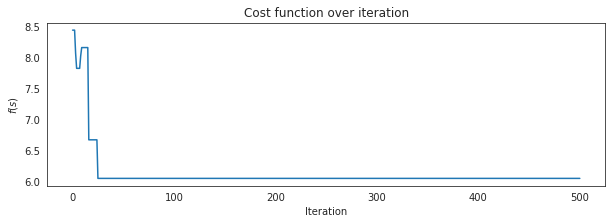

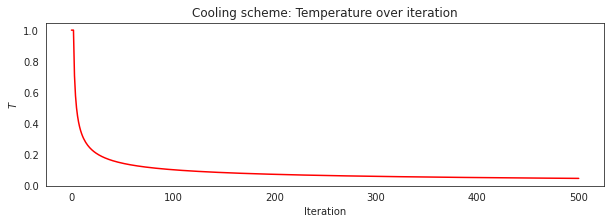

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()

<ipython-input-33-e748231812f6>:34: RuntimeWarning: divide by zero encountered in double_scalars
  T = 1 / np.log(k+1)
Acceptance of proposal: 3.6%


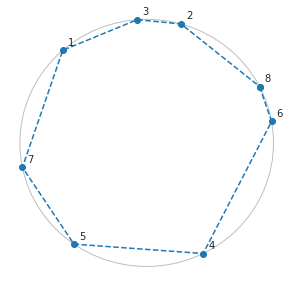

In [ ]:
N_iter = 500
s_opti, costs, temperatures = MH_algorithm_TSP_a(
    station_coords, s_0, N_iter, cooling="log"
)
draw_route(s_opti, station_coords)

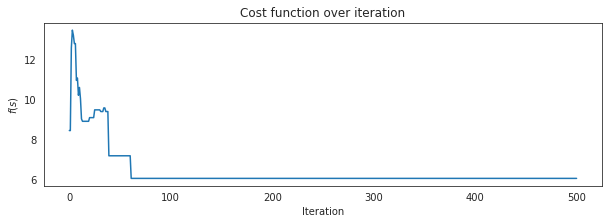

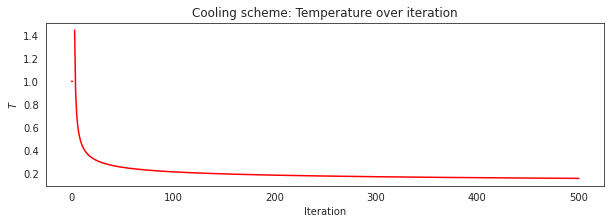

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()

Acceptance of proposal: 25.0%


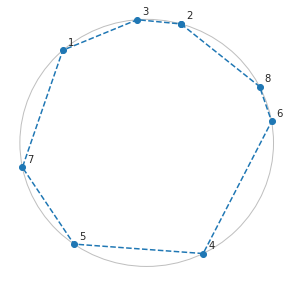

In [ ]:
N_iter = 500
s_opti, costs, temperatures = MH_algorithm_TSP_a(
    station_coords, s_0, N_iter, cooling="linear"
)
draw_route(s_opti, station_coords)

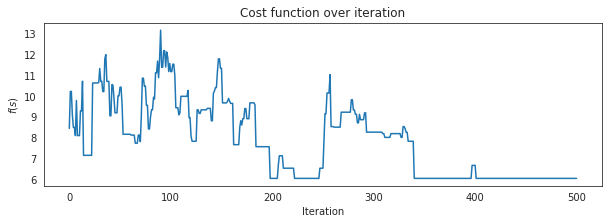

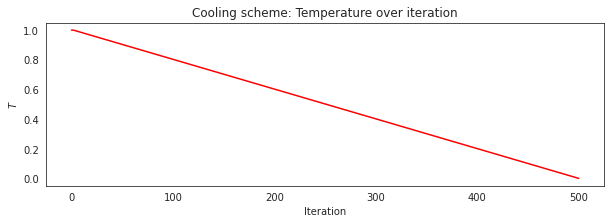

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()

### (b)
**Then modify your progamme to work with costs directly
and apply it to the cost matrix from the course homepage.**

In [ ]:
matrix = np.loadtxt(open("cost.csv", "rb"), delimiter=",")
print(matrix.shape)

(20, 20)


In [ ]:
n = matrix.shape[0]
s_0 = np.random.choice(np.arange(1, n + 1), n, replace=False)
print(s_0)

[15 16  9 12  4 11 14 13  7  5 20 10 19  3  1 17  8  2  6 18]


The cost function $f$, with cost matrix $A$ of shape (n,n), is now
$$
f(s) = \sum_{i=1}^{n-1}A(s_i, s_{i+1}) + A(s_n, s_1) 
$$
NB: The element $A_{i,j}$ is written $A(i,j)$ with $i,j=1,...,n$.

NB: The route $s$ is a list of $n$ distinct stations that have integer values in $\{1,...,n\}$ 

In [ ]:
def cost_function_matrix(s, matrix):
    n = len(s)
    costs = []
    for i in range(n):
        ## wrap around last state
        if i + 1 == n:
            costs += [matrix[s[i] - 1, s[0] - 1]]
        else:
            costs += [matrix[s[i] - 1, s[i + 1] - 1]]

    total_cost = np.sum(costs)
    return total_cost


cost_function_matrix(s_0, matrix)

3502.0

In [ ]:
def MH_algorithm_TSP_b(matrix, s_0, N_iter, cooling="sqrt"):
    T = 1
    s = s_0
    f_s = cost_function_matrix(s, matrix)
    count_accept = 0

    costs = [f_s]
    temperatures = [T]
    for k in range(N_iter):
        # Sample s* from proposal distribution q
        s_star = permute_route(s)
        f_s_star = cost_function_matrix(s_star, matrix)

        # Acceptance probability = min(1, p(s*)/ p(s)) (q symetric)
        alpha = min(1, np.exp((f_s - f_s_star) / T))

        if np.random.uniform() < alpha:
            # Accept
            s = s_star
            f_s = f_s_star
            count_accept += 1

        # Else, reject and s stays s.

        # Keep trace of the iterations
        costs += [f_s]
        temperatures += [T]

        # Update the temperate
        # Cooling scheme
        if cooling == "sqrt":
            T = 1 / np.sqrt(1 + k)
        elif cooling == "log":
            T = 1 / np.log(k + 1)
        elif cooling == "linear":
            T = 1 - (1 * k / N_iter)

    # The optimal route is the last state after all iterations of the algorithm.
    s_opti = s

    print(f"Acceptance of proposal: {100 * count_accept / N_iter}%")

    return s_opti, costs, temperatures

<ipython-input-64-a7f8cd884ed6>:15: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp((f_s - f_s_star)/T))
Acceptance of proposal: 6.8%


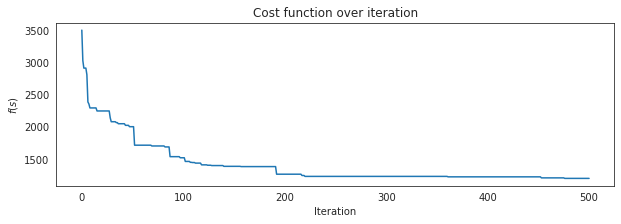

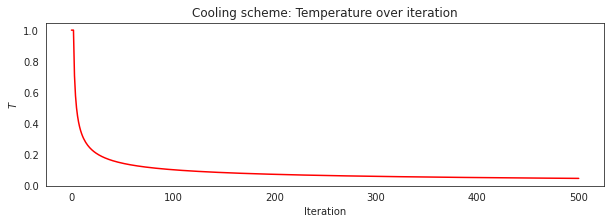

Best* route: [14 15 19 13  4  1  6 12 18 17 10 16  5  8 11  3 20  7  2  9]
with cost: 1202.0


In [ ]:
N_iter = 500
s_opti, costs, temperatures = MH_algorithm_TSP_b(matrix, s_0, N_iter, cooling="sqrt")

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()
print("Best* route:", s_opti)
print("with cost:", costs[-1])

Acceptance of proposal: 7.2%
<ipython-input-64-a7f8cd884ed6>:34: RuntimeWarning: divide by zero encountered in double_scalars
  T = 1 / np.log(k+1)
<ipython-input-64-a7f8cd884ed6>:15: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp((f_s - f_s_star)/T))


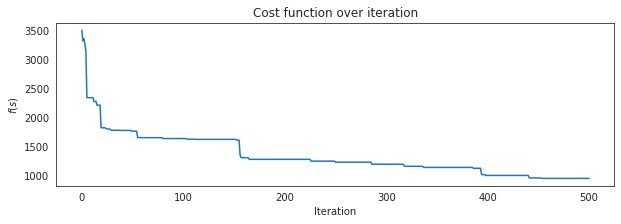

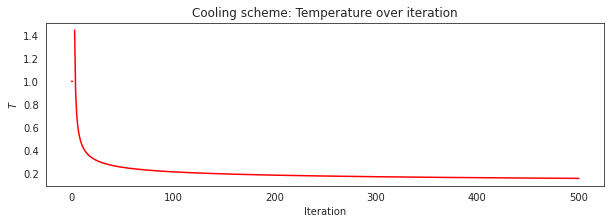

Best* route: [ 7 18 17 12  6 15 19  5 16 10  8  2  9 14  1 13  4  3 11 20]
with cost: 949.0


In [ ]:
N_iter = 500
s_opti, costs, temperatures = MH_algorithm_TSP_b(matrix, s_0, N_iter, cooling="log")

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()
print("Best* route:", s_opti)
print("with cost:", costs[-1])

Acceptance of proposal: 6.2%


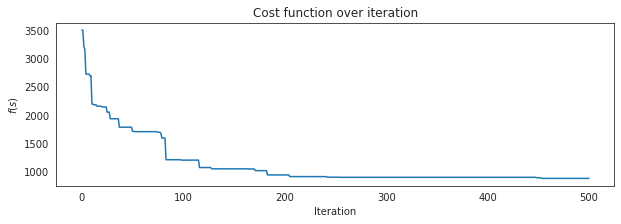

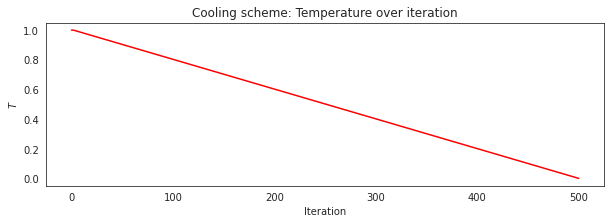

Best* route: [ 2  9 19 15  4 13  1 11  3 20  7 18 17 12  6  8  5 10 16 14]
with cost: 881.0


In [ ]:
N_iter = 500
s_opti, costs, temperatures = MH_algorithm_TSP_b(matrix, s_0, N_iter, cooling="linear")

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), costs)
ax.set(xlabel="Iteration", ylabel=r"$f(s)$", title="Cost function over iteration")
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(np.arange(N_iter + 1), temperatures, c="red")
ax.set(
    xlabel="Iteration",
    ylabel=r"$T$",
    title="Cooling scheme: Temperature over iteration",
)
plt.show()
print("Best* route:", s_opti)
print("with cost:", costs[-1])